In [177]:
import pandas as pd
from itertools import combinations
import pandas as pd
import random
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

In [178]:
# draw corr hot map
def draw_corr_map(df,method='pearson'):
    """
    绘制相关系数热力图
    df: 数据框
    method: 相关系数方法（pearson、kendall或spearman）
    """
    # 计算相关系数矩阵
    corr_map = df.corr(method=method)

    # 设置图表尺寸和字体大小
    sns.set(rc={'figure.figsize':(11, 9), 'font.size': 11})

    # 绘制相关系数热力图
    sns.heatmap(corr_map, annot=True, cmap='coolwarm')

        # 旋转x轴标签
    plt.xticks(rotation=45)
    # 返回相关系数矩阵
    return corr_map

# Apriori算法

In [179]:
# -*- coding: utf-8 -*-
# @Time    : 2022/5/17 9:31
# @Author  : wtQiu
# @File    : __init__.py.py
# @Software: PyCharm

import numpy as np
import pandas as pd


def SingleCandidateSet(DataSet):
    """
    生成数据集中的所有单个项的候选集singleSet
    :param DataSet: 数据集，每行为一个交易
    :return: 1项候选集singleSet
    """
    singleSet = []
    # 遍历数据集中的每一行
    for transaction in DataSet:
        # 遍历交易中的每一个项
        for item in transaction:
            # 如果该项不在候选集singleSet中，则将其添加到singleSet中
            if [item] not in singleSet:
                singleSet.append([item])
    # 对候选集singleSet中的项按中文字符串升序排序
    singleSet.sort()
    # 将singleSet中的每个项转换为不可变的frozenset集合，并将这些集合放入一个新的列表中
    return list(map(frozenset, singleSet))


def calculateSupport(DataSet, CandidateSet, minSupport):
    """
       计算1项候选集的支持度，剔除小于最小支持度的项集
       :param DataSet: 数据集
       :param CandidateSet: 候选集
       :param minSupport: 最小支持度
       :return: 返回1项频繁集及其支持度
       """
    supportCount = {}  # 用于计数的字典
    # 遍历每条数据，对候选集中的每一项进行计数
    for transaction in DataSet:
        for item in CandidateSet:
            # 检查候选集项是否是数据项的子集
            if item.issubset(transaction):
                # 如果之前没有计数，则置为1，否则递增计数
                if item not in supportCount:
                    supportCount[item] = 1
                else:
                    supportCount[item] += 1

    # 总事务数
    totalTransactions = float(len(DataSet))
    # 计算支持度：支持度 = 项集的计数 / 总事务数
    supportData = {}  # 用于存储频繁集的支持度
    frequentSets = []  # 用于存储频繁集
    for item in supportCount:
        support = supportCount[item] / totalTransactions
        # 保存满足最小支持度的频繁项集及其支持度
        if support > minSupport:
            frequentSets.append(item)
            supportData[item] = support

    # 返回1项频繁集及其支持度
    return frequentSets, supportData


def generateCandidates (freqSetK, k):
    """
    使用剪枝算法，减少候选集空间，找到第k项候选集
    :param freqSetK: 第k-1项频繁集
    :param k: 第k项
    :return: 第k项候选集
    """
    candidateList = []  # 存储第k项候选集
    freqSetKLen = len(freqSetK)  # 第k-1项频繁集的长度
    # 两两组合遍历
    for i in range(freqSetKLen):
        for j in range(i + 1, freqSetKLen):
            freqSetK1 = list(freqSetK[i])[:k - 2]
            freqSetK2 = list(freqSetK[j])[:k - 2]
            freqSetK1.sort()
            freqSetK2.sort()
            # 前k-1项相等，则可相乘，这样可以防止重复项出现
            if freqSetK1 == freqSetK2:
                tempSet = freqSetK[i] | freqSetK[j]  # tempSet为frozenset集合
                # 进行剪枝
                tempSet1 = list(tempSet)  # tempSet1为k项集中的一个元素
                b = []  # b为它的所有k-1项子集
                # 构造b:遍历取出每一个元素，转换为set，依次从tempSet1中剔除该元素，并加入到b中
                for q in range(len(tempSet1)):
                    t = [tempSet1[q]]
                    tt = frozenset(set(tempSet1) - set(t))
                    b.append(tt)

                # 当b都是频繁集时，则保留a1,否则，删除
                t = 0
                for w in b:
                    # 如果为True，说明是属于候选集，否则不属于候选集
                    if w in freqSetK:
                        t += 1
                # 如果它的子集都为频繁集，则a1是候选集
                if len(b) == t:
                    candidateList.append(b[0] | b[1])
    return candidateList


def findFrequentSets(transactionList, candidateSet, minSupport):
    """
    计算候选k项集的支持度，筛选出满足最小支持度的频繁k项集及其支持度
    :param transactionList: 数据集
    :param candidateSet: 候选k项集
    :param minSupport: 最小支持度
    :return: 返回频繁k项集及其支持度
    """
    supportCount = {} # 存储支持度计数
    # 统计候选集在数据集中的支持度计数
    for transaction in transactionList:
        for candidate in candidateSet:
            if candidate.issubset(transaction):
                if candidate not in supportCount:
                    supportCount[candidate] = 1
                else:
                    supportCount[candidate] += 1

    numTransactions = len(transactionList)  # 数据集中的事务总数
    frequentSetList = []  # 存储频繁k项集
    supportData = {}  # 存储频繁集对应的支持度

    # 计算支持度并筛选出满足最小支持度的频繁k项集
    for key in supportCount:
        support = supportCount[key] / numTransactions
        if support >= minSupport:
            frequentSetList.append(key)
            supportData[key] = support

    return frequentSetList, supportData


def AprioriMain(DataSet, minSupport=0.2):
    """
    Apriori关联规则算法
    :param DataSet: 数据集
    :param minSupport: 最小支持度
    :return: 返回频繁集及对应的支持度
    """
    # Step 1: 生成1项候选集
    candidateSet1 = SingleCandidateSet(DataSet)
    # 转换数据集为列表形式，用于支持度计算
    transactionList = list(map(set, DataSet))

    # Step 2: 计算1项候选集的支持度，剔除小于最小支持度的项集，返回1项频繁集及其支持度
    frequentSet1, supportData = calculateSupport(transactionList, candidateSet1, minSupport)

    frequentSetList = [frequentSet1]  # 将1项频繁集作为单独的元素存储在列表中

    k = 2  # k项的计数器

    # Step 3: 迭代生成频繁集，直到没有候选集产生
    while len(frequentSetList[k - 2]) > 0:
        # 产生k项候选集Ck
        candidateSetk = generateCandidates(frequentSetList[k - 2], k)

        # Step 4: 计算候选k项集的支持度，剔除小于最小支持度的候选集，得到频繁k项集及其支持度
        frequentSetk, supportK = findFrequentSets(transactionList, candidateSetk, minSupport)

        # 将supportK中的键值对添加到supportData中
        supportData.update(supportK)

        # 将第k项的频繁集添加到frequentSetList中
        frequentSetList.append(frequentSetk)
        k += 1

    del frequentSetList[-1]

    # 返回频繁集及其对应的支持度
    return frequentSetList, supportData


def generate_subsets(OriginSet, GenerateSet):
    """
    生成集合的所有子集
    :param fromSet: 原始集合
    :param totalList: 存储所有子集的列表
    """
    for i in range(len(OriginSet)):
        subset  = [OriginSet[i]]
        remainingSet  = frozenset(set(OriginSet) - set(subset ))  # k-1项子集
        if remainingSet  not in GenerateSet:
            GenerateSet.append(remainingSet )
            remainingSet  = list(remainingSet )
            if len(remainingSet ) > 1:
                generate_subsets(remainingSet , GenerateSet)  # 所有非1项子集

# 关联规则计算

In [ ]:

def calculate_confidence(freqSet, subsets, supportData, ruleList, minConf):
    """
    计算置信度，并剔除小于最小置信度的数据,这里利用了提升度概念
    :param freqSet: k项频繁集
    :param subsets: k项频繁集对应的所有子集
    :param supportData: 支持度
    :param RuleList: 强关联规则
    :param minConf: 最小置信度
    """
    # 遍历freqSet中的所有子集并计算置信度
    global ass_df
    for conseq in subsets:
        pxy = supportData[freqSet]
        px = supportData[conseq]
        py = supportData[freqSet - conseq]
        
        conf = pxy / py  

        # 提升度lift计算lift=p(a&b)/p(a)*p(b)
        lift = pxy / (px * py)
        PS = pxy - (px * py)
        phi = (pxy - (px * py)) / math.sqrt(px*(1-px)*py*(1-py))
        conviction = (1 - py) / (1 - pxy)
        zhangs_metric = (pxy - px * py) / max(px * (1 - py), py * (1 - px))
        if conf >= minConf and lift > 1:
            # 创建新的DataFrame对象
            new_row = {
                'antecedents': freqSet - conseq,
                'consequents': conseq,
                'support': round(supportData[freqSet], 6),
                'confidence': round(conf, 6),
                'lift': round(lift, 6),
                'PS':round(PS, 6),
                'Phi':round(phi, 6),
                'conviction':round(conviction, 6),
                'zhangs_metric':round(zhangs_metric, 6)
            }
            # df = df.append(new_row, ignore_index=True)
            # 将新行数据添加到DataFrame
            ass_df = pd.concat([ass_df, pd.DataFrame([new_row])], ignore_index=True)
            ruleList.append((freqSet - conseq, conseq, conf))

def generate_association_rules(freqSets, supportData, minConf=0.7):
    """
    关联规则：频繁项集中满足最小置信度阈值的关联规则
    :param freqSets: 频繁项集
    :param supportData: 支持度
    :param minConf: 最小置信度
    :return: 返回强关联规则列表
    """
    ruleList = []  # 存储强关联规则
    # 从2项频繁集开始计算置信度
    for i in range(1, len(freqSets)):
        for freqSet in freqSets[i]:
            freqSetList = list(freqSet)
            freqSubset = []  # 存储freqSetList的所有子集
            # 生成所有子集
            generate_subsets(freqSetList, freqSubset)
            # 计算置信度，并剔除小于最小置信度的规则
            calculate_confidence(freqSet, freqSubset, supportData, ruleList, minConf)
    return ruleList

# 特征预处理

In [185]:
df = pd.read_csv('lab3-data.csv',sep=',',encoding='gbk',index_col=0)
cols = ['ST001D01T', 'ST127Q01TA', 'ST127Q02TA', 'GRADE','REPEAT']

new_df = df[cols].copy()  # 使用 .copy() 方法

# SelfGrade、CompareGrade、RepeatFactor特征处理

In [186]:
df = pd.read_csv('lab3-data.csv',sep=',',encoding='gbk',index_col=0)
cols = ['ST001D01T', 'ST127Q01TA', 'ST127Q02TA', 'GRADE','REPEAT']

new_df = df[cols].copy()  # 使用 .copy() 方法

# 将'ST001D01T'列名替换为'SelfGrade'
new_df.rename(columns={'ST001D01T': 'SelfGrade'}, inplace=True)
# 将'GRADE'列名替换为'CompareGrade'
new_df.rename(columns={'GRADE': 'CompareGrade'}, inplace=True)

# 将'ST127Q01TA', 'ST127Q02TA', 'ST127Q03TA'为1的值改为0
new_df[['ST127Q01TA', 'ST127Q02TA']] = new_df[['ST127Q01TA', 'ST127Q02TA']].replace(1, 0)

# 将'ST127Q01TA', 'ST127Q02TA', 'ST127Q03TA'三列相加得到新的一列'RepeatFactor'
new_df['RepeatFactor'] = new_df['ST127Q01TA'] + new_df['ST127Q02TA']

# 删除'ST127Q01TA', 'ST127Q02TA', 'ST127Q03TA'列
new_df.drop(['ST127Q01TA', 'ST127Q02TA'], axis=1, inplace=True)

new_df


,SelfGrade,CompareGrade,REPEAT,RepeatFactor
0,10.0,0.0,0.0,0.0
1,10.0,0.0,0.0,0.0
2,10.0,0.0,0.0,0.0
3,10.0,0.0,0.0,0.0
4,10.0,0.0,0.0,0.0
...,...,...,...,...
42171,10.0,0.0,0.0,0.0
42172,9.0,-1.0,1.0,2.0
42173,10.0,0.0,0.0,0.0
42174,8.0,-2.0,1.0,4.0


# 'PAREDINT','BMMJ1','BFMJ2','HISEI','BSMJ' 特征处理

In [51]:
parcol = ['PAREDINT','BMMJ1','BFMJ2','HISEI','BSMJ']
          
# Index of economic, social and cultural status

pardf = df[parcol].copy()

# 对需要处理的特征列进行选择和判断
for col in pardf.columns:
    # 计算均值和标准差
    mean_val = pardf[col].mean()
    std_val = pardf[col].std()
    # 判断数据是否符合平均值加减三倍标准差或是否为空的条件
    data_filter = ((pardf[col] < mean_val - 3 * std_val) | (pardf[col] > mean_val + 3 * std_val)) | pardf[col].isna()
    if any(data_filter):
        # 对不符合条件的数据用均值填充
        pardf.loc[data_filter, col] = mean_val
        
scaler = MinMaxScaler() 
pardf = pd.DataFrame(scaler.fit_transform(pardf), columns=pardf.columns)
pardf.describe()

pardf

,PAREDINT,BMMJ1,BFMJ2,HISEI,BSMJ
0,0.85,0.577165,0.251187,0.577165,0.718547
1,1.00,0.695574,0.909686,0.909686,0.789860
2,0.60,0.076844,0.224631,0.224631,0.936076
3,1.00,0.842078,0.842078,0.842078,0.601176
4,0.60,0.312123,0.224631,0.312123,0.718547
...,...,...,...,...,...
42171,1.00,0.840026,0.421296,0.840026,0.601176
42172,1.00,0.068890,0.200257,0.200257,0.718547
42173,1.00,0.257473,0.903015,0.903015,0.854372
42174,0.30,0.179987,0.164080,0.179987,0.145040


# 求和 离散化得到 ParentFactor

In [52]:
pardf  = pd.DataFrame({'ParentFactor': pardf.sum(axis=1)})

newpardf = pd.concat([new_df, pardf], axis=1)

# 将ParentFactor列的值进行四舍五入
newpardf['ParentFactor'] = newpardf['ParentFactor'].round()
# newpardf_discretized = pd.DataFrame()
# for col in ['PAREDINT','BMMJ1','BFMJ2','HISEI','BSMJ']:
    # 将属性离散化为5个等间距的区间
#     newpardf_discretized[col] = pd.cut(newpardf[col], 5, labels=['1', '2', '3', '4', '5'])
    
# newpardf = pd.concat([new_df, newpardf_discretized], axis=1)

newpardf

,SelfGrade,CompareGrade,REPEAT,RepeatFactor,ParentFactor
0,10.0,0.0,0.0,0.0,3.0
1,10.0,0.0,0.0,0.0,4.0
2,10.0,0.0,0.0,0.0,2.0
3,10.0,0.0,0.0,0.0,4.0
4,10.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...
42171,10.0,0.0,0.0,0.0,4.0
42172,9.0,-1.0,1.0,2.0,2.0
42173,10.0,0.0,0.0,0.0,4.0
42174,8.0,-2.0,1.0,4.0,1.0


# ESCS特征处理  经济社会文化指标

In [53]:
esdf =  df['ESCS'].copy()

# 计算平均值和标准差
mean_es = esdf.mean()
std_es = esdf.std()

# 将符合条件的数据替换为平均值
esdf[(esdf < mean_es - 3 * std_es) | (esdf > mean_es + 3 * std_es) | (esdf.isnull())] = mean_es

# 归一化到-1,1区间
scaler = MinMaxScaler(feature_range=(-1, 1))
esdf = scaler.fit_transform(pd.DataFrame(esdf))

# 将'esdf_normalized'转换为 DataFrame 对象
esdf = pd.DataFrame(esdf, columns=['ESCS_normalized'])

esdf.describe()

,ESCS_normalized
count,42176.000000
mean,0.008479
std,0.330604
min,-1.000000
25%,-0.226510
50%,0.032466
75%,0.279280
max,1.000000


# 归一 离散化  得到 PowerIndex

In [187]:
# 将归一化后的'ESCS'列进行离散化，分成4个区间，并将区间的边界值设为0
bins = [-1, -0.5, 0, 0.5, 1]
labels = [-1, 0, 1, 2]
esdf['ESCS_Dis'] = pd.cut(esdf['ESCS_normalized'], bins=bins, labels=labels, include_lowest=True)

# 将离散化后的'ESCS_discretized'列转换为整型
esdf['ESCS_Dis'] = esdf['ESCS_Dis'].dropna().astype(int)

esdf.describe()

,ESCS_normalized,ESCS_Dis
count,42176.000000,42175.000000
mean,0.008479,0.500960
std,0.330604,0.691316
min,-1.000000,-1.000000
25%,-0.226510,0.000000
50%,0.032466,1.000000
75%,0.279280,1.000000
max,1.000000,2.000000


# 最终特征 SelfGrade CompareGrade RepeatFactor	ParentFactor	PowerIndex

In [316]:
final_df =  pd.concat([newpardf, esdf['ESCS_Dis']], axis=1)

final_df['RepeatFactor'].fillna(2, inplace=True)

# 将REPEAT列的缺失值用1填充
final_df['REPEAT'].fillna(0, inplace=True)

# 将ESCS_Dis列的缺失值用众数填充
ed_mode = final_df['ESCS_Dis'].mode()[0]
final_df['ESCS_Dis'].fillna(ed_mode, inplace=True)
final_df.rename(columns={'ESCS_Dis': 'PowerIndex'}, inplace=True)

# final_df =  pd.concat([newpardf, df['MISCED']], axis=1)
final_df =  pd.concat([newpardf, df['ISCEDL']], axis=1)
final_df.drop('CompareGrade', axis=1, inplace=True)
final_df.rename(columns={'ISCEDL': 'EduIndex'}, inplace=True)
final_df

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,10.0,0.0,0.0,3.0,3.0
1,10.0,0.0,0.0,4.0,3.0
2,10.0,0.0,0.0,2.0,3.0
3,10.0,0.0,0.0,4.0,3.0
4,10.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...
42171,10.0,0.0,0.0,4.0,2.0
42172,9.0,1.0,2.0,2.0,2.0
42173,10.0,0.0,0.0,4.0,2.0
42174,8.0,1.0,4.0,1.0,2.0


# 相关系数热力图

x:\pycharm\projects\venv\lib\site-packages\seaborn\matrix.py:306: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

x:\pycharm\projects\venv\lib\site-packages\seaborn\matrix.py:316: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



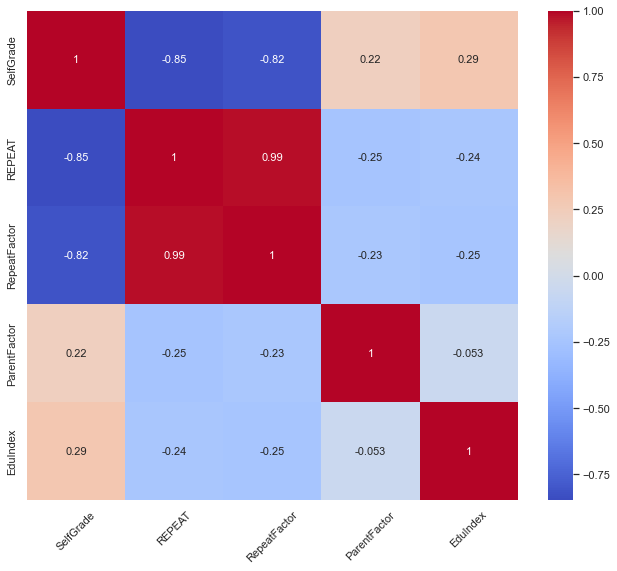

In [317]:
highcorr_map = draw_corr_map(final_df,'spearman')

# 特征变换  取值+列名 字符串

In [318]:
# 将'final_df'中非空的值加上列名得到一个新的 DataFrame
oridf = pd.DataFrame(columns=final_df.columns)

# df_with_colnames = pd.concat([df_with_colnames, pardf], axis=1)

for col in final_df.columns:
    mask = final_df[col].notnull()
    oridf[col] = col + ' ' + final_df.loc[mask, col].astype(str)
    
#     删除'df_with_colnames'中包含缺失值的行
oridf.dropna(inplace=True)

# 重置索引
oridf.reset_index(drop=True, inplace=True)


# 假设 df_with_colnames 是一个 DataFrame 对象，其中包含多列数据
# df_with_colnames.drop(columns=['SelfGrade','CompareGrade','RepeatFactor'], inplace=True)

# 打印输出新的 DataFrame
# oridf
# oridf.drop('SelfGrade', axis=1, inplace=True)
oridf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
1,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
2,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
3,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
4,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
...,...,...,...,...,...
38631,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 2.0
38632,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 2.0
38633,SelfGrade 9.0,REPEAT 1.0,RepeatFactor 2.0,ParentFactor 2.0,EduIndex 2.0
38634,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 2.0


# 不复读远多于复读

In [202]:
repeat_counts = oridf['REPEAT'].value_counts()
repeat_ratios = repeat_counts / len(oridf)

print("REPEAT value counts:")
print(repeat_counts)
print("\nREPEAT value ratios:")
print(repeat_ratios)

REPEAT value counts:
REPEAT 0.0    33477
REPEAT 1.0     8699
Name: REPEAT, dtype: int64

REPEAT value ratios:
REPEAT 0.0    0.793745
REPEAT 1.0    0.206255
Name: REPEAT, dtype: float64


In [287]:
# new_oridf = oridf[oridf['REPEAT'] == 'REPEAT 1.0'].copy()
new_oridf = oridf.copy()
rows_list = []
rows_list = new_oridf.values.tolist()

rows_list

[['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 3.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 4.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 2.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 4.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 2.0',
  'EduIndex 3.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 0.0',
  'ParentFactor 4.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 4.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 2.0',
  'EduIndex 3.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 0.0',
  'ParentFactor 2.0',
  'EduIndex 3.0'],
 ['SelfGrade 10.0',
  'REPEAT 0.0',
  'RepeatFactor 0.0',
  'ParentFactor 1.0',
  'EduIndex 3.0'],
 ['SelfGrade

In [293]:
ass_df = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift','PS','Phi','conviction','zhangs_metric'])

# 返回频繁集及其对应的支持度
L, supportData = AprioriMain(rows_list, minSupport=0.09)


supportData1 = {}
for key, value in supportData.items():
    if 'REPEAT 1.0' in key:
        supportData1[key] = value
        
for key, value in supportData1.items():
    print("{:<100}{:.16f}".format(str(key), value))

frozenset({'REPEAT 1.0'})                                                                           0.1455119577596024
frozenset({'REPEAT 1.0', 'SelfGrade 9.0'})                                                          0.1047209856092763
frozenset({'REPEAT 1.0', 'RepeatFactor 2.0'})                                                       0.1082927839320841
frozenset({'REPEAT 1.0', 'EduIndex 2.0'})                                                           0.1340977326845429
frozenset({'REPEAT 1.0', 'SelfGrade 9.0', 'RepeatFactor 2.0'})                                      0.0987421058080547
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0'})                                       0.1019256651827311
frozenset({'EduIndex 2.0', 'REPEAT 1.0', 'SelfGrade 9.0'})                                          0.0987162232115126
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0', 'SelfGrade 9.0'})                      0.0947044207474894


In [294]:
# 生成强关联规则
rule = generate_association_rules(L, supportData, minConf=0.15)


In [295]:
# filtered_df = ass_df[ass_df['consequents'] == "frozenset({'REPEAT 1.0'})"]
filtered_df = ass_df[ass_df['consequents'].apply(lambda x: x == frozenset(['REPEAT 1.0']))]
filtered_df = filtered_df.drop(['support','conviction', 'zhangs_metric'], axis=1)
filtered_df

,antecedents,consequents,confidence,lift,PS,Phi
27,(SelfGrade 9.0),(REPEAT 1.0),0.787313,5.410639,0.085366,0.712909
29,(RepeatFactor 2.0),(REPEAT 1.0),1.0,6.872287,0.092535,0.844486
33,(EduIndex 2.0),(REPEAT 1.0),0.205661,1.413358,0.039219,0.233502
133,"(SelfGrade 9.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,6.872287,0.084374,0.802103
143,"(EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,6.872287,0.087094,0.816374
163,"(SelfGrade 9.0, EduIndex 2.0)",(REPEAT 1.0),0.83567,5.742968,0.081527,0.716342
315,"(SelfGrade 9.0, EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,6.872287,0.080924,0.783779


In [209]:
consequents_values = ass_df['consequents'].unique()
print(consequents_values)


[frozenset({'ParentFactor 3.0'}) frozenset({'CompareGrade 0.0'})
 frozenset({'REPEAT 0.0'}) frozenset({'RepeatFactor 0.0'})
 frozenset({'SelfGrade 10.0'}) frozenset({'ESCS_Dis 1.0'})
 frozenset({'ParentFactor 4.0'}) frozenset({'ParentFactor 2.0'})
 frozenset({'ESCS_Dis 0.0'}) frozenset({'CompareGrade -1.0'})
 frozenset({'REPEAT 1.0'}) frozenset({'SelfGrade 9.0'})
 frozenset({'ParentFactor 1.0'}) frozenset({'ESCS_Dis -1.0'})
 frozenset({'RepeatFactor 2.0'}) frozenset({'SelfGrade 11.0'})
 frozenset({'CompareGrade 1.0'}) frozenset({'ParentFactor 5.0'})
 frozenset({'ESCS_Dis 2.0'}) frozenset({'CompareGrade -2.0'})
 frozenset({'SelfGrade 8.0'}) frozenset({'RepeatFactor 4.0'})
 frozenset({'ESCS_Dis 0.0', 'REPEAT 0.0'})
 frozenset({'ESCS_Dis 0.0', 'CompareGrade 0.0'})
 frozenset({'ESCS_Dis 0.0', 'RepeatFactor 0.0'})
 frozenset({'ESCS_Dis 0.0', 'SelfGrade 10.0'})
 frozenset({'ParentFactor 3.0', 'REPEAT 0.0'})
 frozenset({'CompareGrade 0.0', 'REPEAT 0.0'})
 frozenset({'CompareGrade 0.0', 'Paren

In [211]:
ass_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4558 entries, 0 to 4557
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   antecedents  4558 non-null   object 
 1   consequents  4558 non-null   object 
 2   support      4558 non-null   float64
 3   confidence   4558 non-null   float64
 4   lift         4558 non-null   float64
dtypes: float64(3), object(2)
memory usage: 178.2+ KB


# 不同国家

In [357]:

df_cnt = df['REPEAT'].value_counts()
    
    # 绘制饼图
fig = px.pie(values=df_cnt.values, names=df_cnt.index, title='total')
    
    # 显示图形
fig.show()

In [319]:
cntdf = pd.concat([final_df, df[['CNTRYID']]], axis=1)
cntdf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex,CNTRYID
0,10.0,0.0,0.0,3.0,3.0,152.0
1,10.0,0.0,0.0,4.0,3.0,152.0
2,10.0,0.0,0.0,2.0,3.0,152.0
3,10.0,0.0,0.0,4.0,3.0,152.0
4,10.0,0.0,0.0,2.0,3.0,152.0
...,...,...,...,...,...,...
42171,10.0,0.0,0.0,4.0,2.0,724.0
42172,9.0,1.0,2.0,2.0,2.0,724.0
42173,10.0,0.0,0.0,4.0,2.0,724.0
42174,8.0,1.0,4.0,1.0,2.0,724.0


In [320]:


# 按照CNTRYID分组并将分组后的数据框存储在一个字典中
# dfs = {group: data for group, data in df.groupby('CNTRYID')}
Chile =  pd.DataFrame()
Rica =  pd.DataFrame()
Dominican  =  pd.DataFrame()
Mexico =  pd.DataFrame()
Panama =  pd.DataFrame()
Spain =  pd.DataFrame()
for group, data in cntdf.groupby('CNTRYID'):
    if group == 152.0:
        Chile = data
    elif group == 188.0:
        CostaRica = data
    elif group == 214.0:
        DominicanRepublic = data
    elif group == 484.0:
        Mexico = data
    elif group == 591.0:
        Panama = data
    elif group == 724.0:
        Spain = data
    else:
        print(f"Group {group}:")
        print(data)

# 智利

In [321]:

Chile_cnt = Chile['REPEAT'].value_counts()
    
    # 绘制饼图
fig = px.pie(values=Chile_cnt.values, names=Chile_cnt.index, title='Chile')
    
    # 显示图形
fig.show()

In [391]:
# 将'final_df'中非空的值加上列名得到一个新的 DataFrame
Chiledf = pd.DataFrame(columns=Chile.columns)

# df_with_colnames = pd.concat([df_with_colnames, pardf], axis=1)

for col in Chile.columns:
    mask = Chile[col].notnull()
    Chiledf[col] = col + ' ' + Chile.loc[mask, col].astype(str)
    
#     删除'df_with_colnames'中包含缺失值的行
Chiledf.dropna(inplace=True)

# 重置索引
Chiledf.reset_index(drop=True, inplace=True)
Chiledf = Chiledf.drop('CNTRYID', axis=1)
Chiledf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
1,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
2,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
3,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
4,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
...,...,...,...,...,...
5032,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
5033,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
5034,SelfGrade 8.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 1.0,EduIndex 2.0
5035,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0


In [323]:
Chile

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex,CNTRYID
0,10.0,0.0,0.0,3.0,3.0,152.0
1,10.0,0.0,0.0,4.0,3.0,152.0
2,10.0,0.0,0.0,2.0,3.0,152.0
3,10.0,0.0,0.0,4.0,3.0,152.0
4,10.0,0.0,0.0,2.0,3.0,152.0
...,...,...,...,...,...,...
5671,10.0,0.0,0.0,4.0,3.0,152.0
5672,8.0,0.0,0.0,1.0,2.0,152.0
5673,10.0,0.0,0.0,2.0,3.0,152.0
5674,9.0,1.0,NaN,1.0,3.0,152.0


In [413]:
Mexicodf1 = Mexicodf[Mexicodf['REPEAT'] == 'REPEAT 1.0'].copy()
rows_list = []
rows_list = Mexicodf1.values.tolist()

rows_list

[['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
 

In [414]:
ass_df = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift','PS','Phi','conviction','zhangs_metric'])

# 返回频繁集及其对应的支持度
L, supportData = AprioriMain(rows_list, minSupport=0.6)


supportData1 = {}
for key, value in supportData.items():
    if 'REPEAT 1.0' in key:
        supportData1[key] = value
        
for key, value in supportData1.items():
    print("{:<100}{:.16f}".format(str(key), value))

frozenset({'REPEAT 1.0'})                                                                           1.0000000000000000
frozenset({'REPEAT 1.0', 'EduIndex 2.0'})                                                           0.8457300275482094
frozenset({'REPEAT 1.0', 'SelfGrade 9.0'})                                                          0.6666666666666666
frozenset({'REPEAT 1.0', 'RepeatFactor 2.0'})                                                       0.8044077134986226
frozenset({'SelfGrade 9.0', 'REPEAT 1.0', 'EduIndex 2.0'})                                          0.6666666666666666
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0'})                                       0.7685950413223140
frozenset({'REPEAT 1.0', 'SelfGrade 9.0', 'RepeatFactor 2.0'})                                      0.6501377410468320
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0', 'SelfGrade 9.0'})                      0.6501377410468320


In [408]:
# 生成强关联规则
rule = generate_association_rules(L, supportData, minConf=0.15)


In [409]:
# filtered_df = ass_df[ass_df['consequents'] == "frozenset({'REPEAT 1.0'})"]
filtered_df = ass_df[ass_df['consequents'].apply(lambda x: x == frozenset(['REPEAT 1.0']))]
filtered_df = filtered_df.drop(['support','conviction', 'zhangs_metric'], axis=1)
filtered_df

,antecedents,consequents,confidence,lift,PS,Phi
31,(EduIndex 2.0),(REPEAT 1.0),0.533913,8.311688,0.04779,0.64476
33,(SelfGrade 9.0),(REPEAT 1.0),0.495902,7.719945,0.037277,0.541293
37,(RepeatFactor 2.0),(REPEAT 1.0),1.0,15.567493,0.048353,0.890927
178,"(EduIndex 2.0, SelfGrade 9.0)",(REPEAT 1.0),0.495902,7.719945,0.037277,0.541293
186,"(EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.0462,0.869814
198,"(SelfGrade 9.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.03908,0.7968
399,"(SelfGrade 9.0, EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.03908,0.7968


# 墨西哥

In [324]:

Mexico_cnt = Mexico['REPEAT'].value_counts()
    
    # 绘制饼图
fig = px.pie(values=Mexico_cnt.values, names=Mexico_cnt.index, title='Mexico')
    
    # 显示图形
fig.show()

In [377]:
# 将'final_df'中非空的值加上列名得到一个新的 DataFrame
Mexicodf = pd.DataFrame(columns=Mexico.columns)

# df_with_colnames = pd.concat([df_with_colnames, pardf], axis=1)

for col in Mexico.columns:
    mask = Mexico[col].notnull()
    Mexicodf[col] = col + ' ' + Mexico.loc[mask, col].astype(str)
    
#     删除'df_with_colnames'中包含缺失值的行
Mexicodf.dropna(inplace=True)

# 重置索引
Mexicodf.reset_index(drop=True, inplace=True)
Mexicodf = Mexicodf.drop('CNTRYID', axis=1)
Mexicodf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
1,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
2,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
3,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
4,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
...,...,...,...,...,...
5646,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 1.0,EduIndex 3.0
5647,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 1.0,EduIndex 3.0
5648,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0
5649,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0


In [410]:
Mexicodf1 = Mexicodf[Mexicodf['REPEAT'] == 'REPEAT 1.0'].copy()
rows_list = []
rows_list = Mexicodf1.values.tolist()

rows_list

[['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
 

In [411]:
ass_df = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift','PS','Phi','conviction','zhangs_metric'])

# 返回频繁集及其对应的支持度
L, supportData = AprioriMain(rows_list, minSupport=0.6)


supportData1 = {}
for key, value in supportData.items():
    if 'REPEAT 1.0' in key:
        supportData1[key] = value
        
for key, value in supportData1.items():
    print("{:<100}{:.16f}".format(str(key), value))

frozenset({'REPEAT 1.0'})                                                                           1.0000000000000000
frozenset({'REPEAT 1.0', 'EduIndex 2.0'})                                                           0.8457300275482094
frozenset({'REPEAT 1.0', 'SelfGrade 9.0'})                                                          0.6666666666666666
frozenset({'REPEAT 1.0', 'RepeatFactor 2.0'})                                                       0.8044077134986226
frozenset({'SelfGrade 9.0', 'REPEAT 1.0', 'EduIndex 2.0'})                                          0.6666666666666666
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0'})                                       0.7685950413223140
frozenset({'REPEAT 1.0', 'SelfGrade 9.0', 'RepeatFactor 2.0'})                                      0.6501377410468320
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0', 'SelfGrade 9.0'})                      0.6501377410468320


In [389]:
# 生成强关联规则
rule = generate_association_rules(L, supportData, minConf=0.15)


In [390]:
# filtered_df = ass_df[ass_df['consequents'] == "frozenset({'REPEAT 1.0'})"]
filtered_df = ass_df[ass_df['consequents'].apply(lambda x: x == frozenset(['REPEAT 1.0']))]
filtered_df = filtered_df.drop(['support','conviction', 'zhangs_metric'], axis=1)
filtered_df

,antecedents,consequents,confidence,lift,PS,Phi
31,(EduIndex 2.0),(REPEAT 1.0),0.533913,8.311688,0.04779,0.64476
33,(SelfGrade 9.0),(REPEAT 1.0),0.495902,7.719945,0.037277,0.541293
37,(RepeatFactor 2.0),(REPEAT 1.0),1.0,15.567493,0.048353,0.890927
178,"(EduIndex 2.0, SelfGrade 9.0)",(REPEAT 1.0),0.495902,7.719945,0.037277,0.541293
186,"(EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.0462,0.869814
198,"(SelfGrade 9.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.03908,0.7968
399,"(SelfGrade 9.0, EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,15.567493,0.03908,0.7968


# 巴拿马

In [326]:
Panama_cnt = Panama['REPEAT'].value_counts()
    
    # 绘制饼图
fig = px.pie(values=Panama_cnt.values, names=Panama_cnt.index, title='Panama')
    
    # 显示图形
fig.show()

In [348]:
# 将'final_df'中非空的值加上列名得到一个新的 DataFrame
Panamadf = pd.DataFrame(columns=Panama.columns)

# df_with_colnames = pd.concat([df_with_colnames, pardf], axis=1)

for col in Panama.columns:
    mask = Panama[col].notnull()
    Panamadf[col] = col + ' ' + Panama.loc[mask, col].astype(str)
    
#     删除'df_with_colnames'中包含缺失值的行
Panamadf.dropna(inplace=True)

# 重置索引
Panamadf.reset_index(drop=True, inplace=True)

Panamadf = Panamadf.drop('CNTRYID', axis=1)

Panamadf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,SelfGrade 7.0,REPEAT 1.0,RepeatFactor 2.0,ParentFactor 2.0,EduIndex 2.0
1,SelfGrade 11.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
2,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 1.0,EduIndex 3.0
3,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
4,SelfGrade 9.0,REPEAT 1.0,RepeatFactor 2.0,ParentFactor 2.0,EduIndex 2.0
...,...,...,...,...,...
3856,SelfGrade 10.0,REPEAT 1.0,RepeatFactor 4.0,ParentFactor 2.0,EduIndex 3.0
3857,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 3.0
3858,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 3.0
3859,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 3.0


In [416]:
Panama1 = Panamadf[Panamadf['REPEAT'] == 'REPEAT 1.0'].copy()
rows_list = []
rows_list = Panama1.values.tolist()

rows_list

[['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 4.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 4.0',
  'EduIndex 2.0'],
 ['SelfGrade 7.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 3.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
 

In [418]:
ass_df = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift','PS','Phi','conviction','zhangs_metric'])

# 返回频繁集及其对应的支持度
L, supportData = AprioriMain(rows_list, minSupport=0.5)


supportData1 = {}
for key, value in supportData.items():
    if 'REPEAT 1.0' in key:
        supportData1[key] = value
        
for key, value in supportData1.items():
    print("{:<100}{:.16f}".format(str(key), value))

frozenset({'REPEAT 1.0'})                                                                           1.0000000000000000
frozenset({'REPEAT 1.0', 'EduIndex 2.0'})                                                           0.7886178861788617
frozenset({'REPEAT 1.0', 'RepeatFactor 2.0'})                                                       0.5853658536585366
frozenset({'REPEAT 1.0', 'SelfGrade 9.0'})                                                          0.5264227642276422
frozenset({'SelfGrade 9.0', 'REPEAT 1.0', 'EduIndex 2.0'})                                          0.5264227642276422


In [373]:
# 生成强关联规则
rule = generate_association_rules(L, supportData, minConf=0.15)


In [374]:
# filtered_df = ass_df[ass_df['consequents'] == "frozenset({'REPEAT 1.0'})"]
filtered_df = ass_df[ass_df['consequents'].apply(lambda x: x == frozenset(['REPEAT 1.0']))]
filtered_df = filtered_df.drop(['support','conviction', 'zhangs_metric'], axis=1)
filtered_df

,antecedents,consequents,confidence,lift,PS,Phi
1,(EduIndex 2.0),(REPEAT 1.0),0.656514,5.152037,0.080987,0.674548


# 西班牙

In [328]:
Spain_cnt = Spain['REPEAT'].value_counts()
    
    # 绘制饼图
fig = px.pie(values=Spain_cnt.values, names=Spain_cnt.index, title='Spain')
    
    # 显示图形
fig.show()

In [329]:
# 将'final_df'中非空的值加上列名得到一个新的 DataFrame
Spaindf = pd.DataFrame(columns=Spain.columns)



# df_with_colnames = pd.concat([df_with_colnames, pardf], axis=1)

for col in Spain.columns:
    mask = Spain[col].notnull()
    Spaindf[col] = col + ' ' + Spain.loc[mask, col].astype(str)
    
#     删除'df_with_colnames'中包含缺失值的行
Spaindf.dropna(inplace=True)

# 重置索引
Spaindf.reset_index(drop=True, inplace=True)

Spaindf = Spaindf.drop('CNTRYID', axis=1)

Spaindf

,SelfGrade,REPEAT,RepeatFactor,ParentFactor,EduIndex
0,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 2.0
1,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 2.0
2,SelfGrade 8.0,REPEAT 1.0,RepeatFactor 4.0,ParentFactor 2.0,EduIndex 2.0
3,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 3.0,EduIndex 2.0
4,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 2.0
...,...,...,...,...,...
23977,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 2.0,EduIndex 2.0
23978,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 2.0
23979,SelfGrade 9.0,REPEAT 1.0,RepeatFactor 2.0,ParentFactor 2.0,EduIndex 2.0
23980,SelfGrade 10.0,REPEAT 0.0,RepeatFactor 0.0,ParentFactor 4.0,EduIndex 2.0


In [334]:
Spaindf1 = Spaindf[Spaindf['REPEAT'] == 'REPEAT 1.0'].copy()
rows_list = []
rows_list = Spaindf1.values.tolist()

rows_list

[['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 10.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 1.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 8.0',
  'REPEAT 1.0',
  'RepeatFactor 4.0',
  'ParentFactor 2.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',
  'REPEAT 1.0',
  'RepeatFactor 2.0',
  'ParentFactor 3.0',
  'EduIndex 2.0'],
 ['SelfGrade 9.0',


In [335]:
ass_df = pd.DataFrame(columns=['antecedents', 'consequents', 'support', 'confidence', 'lift','PS','Phi','conviction','zhangs_metric'])

# 返回频繁集及其对应的支持度
L, supportData = AprioriMain(rows_list, minSupport=0.6)


supportData1 = {}
for key, value in supportData.items():
    if 'REPEAT 1.0' in key:
        supportData1[key] = value
        
for key, value in supportData1.items():
    print("{:<100}{:.16f}".format(str(key), value))

frozenset({'REPEAT 1.0'})                                                                           1.0000000000000000
frozenset({'REPEAT 1.0', 'EduIndex 2.0'})                                                           1.0000000000000000
frozenset({'REPEAT 1.0', 'RepeatFactor 2.0'})                                                       0.7666666666666667
frozenset({'REPEAT 1.0', 'SelfGrade 9.0'})                                                          0.7461711711711712
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0'})                                       0.7666666666666667
frozenset({'SelfGrade 9.0', 'REPEAT 1.0', 'EduIndex 2.0'})                                          0.7461711711711712
frozenset({'REPEAT 1.0', 'SelfGrade 9.0', 'RepeatFactor 2.0'})                                      0.7252252252252253
frozenset({'REPEAT 1.0', 'EduIndex 2.0', 'RepeatFactor 2.0', 'SelfGrade 9.0'})                      0.7252252252252253


In [332]:
# 生成强关联规则
rule = generate_association_rules(L, supportData, minConf=0.15)


In [333]:
# filtered_df = ass_df[ass_df['consequents'] == "frozenset({'REPEAT 1.0'})"]
filtered_df = ass_df[ass_df['consequents'].apply(lambda x: x == frozenset(['REPEAT 1.0']))]
filtered_df = filtered_df.drop(['support','conviction', 'zhangs_metric'], axis=1)
filtered_df

,antecedents,consequents,confidence,lift,PS,Phi
23,(EduIndex 2.0),(REPEAT 1.0),0.185247,1.000584,0.000108,0.01152
28,(RepeatFactor 2.0),(REPEAT 1.0),1.0,5.401351,0.115661,0.853269
30,(SelfGrade 9.0),(REPEAT 1.0),0.910916,4.920175,0.110068,0.790051
140,"(EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,5.401351,0.115661,0.853269
144,"(EduIndex 2.0, SelfGrade 9.0)",(REPEAT 1.0),0.910916,4.920175,0.110068,0.790051
156,"(SelfGrade 9.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,5.401351,0.109409,0.826202
330,"(SelfGrade 9.0, EduIndex 2.0, RepeatFactor 2.0)",(REPEAT 1.0),1.0,5.401351,0.109409,0.826202
